In [ ]:
%load_ext autoreload
%autoreload 2
import sys
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
import sasc.viz
import joblib
import dvu
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR
from neuro.config import repo_dir
from neuro import analyze_helper, viz
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
from load_coef_flatmaps import _load_coefs_35questions, _load_coefs_individual, _load_coefs_individual_wordrate, _load_coefs_wordrate
flatmaps_per_question = __import__('06_flatmaps_per_question')
from neurosynth import term_dict, term_dict_rev
import viz

# Load fitted models

In [ ]:
# subject = 'S02'
for subject in ['S01', 'S02', 'S03']:
    # jointly fitted 35-question model
    df_w_selected35 = _load_coefs_35questions(subject=subject)

    # individually fitted question models
    df_w_individual = _load_coefs_individual(subject=subject)

    # individually fitted question models *with wordrate
    df_w_individual_wordrate = _load_coefs_individual_wordrate(
        subject=subject)

    # wordrate
    df_w_wordrate_alone = _load_coefs_wordrate(subject=subject)

    # collate individual dfs #########################
    # average weights for df_w_selected35 and df_w_individual
    if subject == 'S02':
        df_avg = df_w_selected35.merge(df_w_individual, on='question')
        df_avg['weights'] = df_avg.apply(
            lambda x: np.mean([x['weights_x'], x['weights_y']], axis=0), axis=1)

    df_avg_individual = df_w_individual.merge(
        df_w_individual_wordrate, on='question')
    df_avg_individual['weights'] = df_avg_individual.apply(
        lambda x: np.mean([x['weights_x'], x['weights_y']], axis=0), axis=1)

    df_qa_dict = {
        'selected35': df_w_selected35,
        'individual': df_w_individual,
        'individual_wordrate': df_w_individual_wordrate,
        'wordrate_alone': df_w_wordrate_alone,
        # 'avg': df_avg,
        'avg_individual': df_avg_individual
    }
    joblib.dump(df_qa_dict, f'df_qa_dict_{subject}.pkl')

# Load "groundtruth" comparisons

### load gemv average flatmaps

In [3]:
gemv_avgs_pilot = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot.pkl'))
gemv_avgs_pilot5 = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot5.pkl'))
gemv_avg_flatmaps = gemv_avgs_pilot | gemv_avgs_pilot5

### load neurosynth avg. flatmaps

In [10]:
def get_neurosynth_flatmaps(subject, neurosynth_dir='/home/chansingh/mntv1/deep-fMRI/qa/neurosynth_data'):
    subject_s = subject.replace('UT', '')
    # neurosynth_dir = '/home/chansingh/mntv1/deep-fMRI/qa/neurosynth_data/all_association-test_z'

    term_names = [k.replace('.nii.gz', '').replace(
        '_association-test_z', '') for k in os.listdir(join(neurosynth_dir, f'all_in_{subject_s}-BOLD'))]

    # filter dict for files that were in neurosynth
    term_dict_ = {k: v for k, v in term_dict.items() if k in term_names}
    # for k in term_dict.keys():
    #     if k not in term_names:
    #         print(k)

    # filter dict for files that had questions run
    questions_run = [k.replace('.pkl', '') for k in os.listdir(
        '/home/chansingh/mntv1/deep-fMRI/qa/cache_gpt')]
    term_dict_ = {k: v for k, v in term_dict_.items() if v in questions_run}

    def _load_flatmap(term, neurosynth_dir, subject):
        # output_file = join(neurosynth_dir, f'{term}_association-test_z.nii.gz')
        output_file = join(
            neurosynth_dir, f'all_in_{subject_s}-BOLD/{term}.nii.gz')
        vol = cortex.Volume(output_file, subject, subject + '_auto').data
        mask = cortex.db.get_mask(subject, subject + '_auto')
        return vol[mask]

    return {q: _load_flatmap(
        term, neurosynth_dir, subject) for (term, q) in term_dict_.items()}

In [11]:
setting = 'avg_individual'
corrs_df_list = defaultdict(list)
for subject in ['UTS01', 'UTS02', 'UTS03']:
    neurosynth_flatmaps = get_neurosynth_flatmaps(subject)
    df_qa_dict = joblib.load(f'df_qa_dict_{subject.replace("UT", "")}.pkl')
    qa_flatmaps = df_qa_dict[setting].to_dict()['weights']

    # get common flatmaps and put into d
    common_keys = set(neurosynth_flatmaps.keys()) & set(
        qa_flatmaps.keys())
    d = defaultdict(list)
    for k in common_keys:
        d['questions'].append(k)
        d['corr'].append(np.corrcoef(qa_flatmaps[k],
                                     neurosynth_flatmaps[k])[0, 1])
        d['flatmap_qa'].append(qa_flatmaps[k])
        d['flatmap_neurosynth'].append(neurosynth_flatmaps[k])
    d = pd.DataFrame(d).sort_values('corr', ascending=False)

    corrs = viz._calc_corrs(
        d['flatmap_qa'].values,
        d['flatmap_neurosynth'].values,
        titles_qa=d['questions'].values,
        titles_gt=d['questions'].values,
    )

    corrs_df_list['corrs'].extend(np.diag(corrs).tolist())
    corrs_df_list['questions'].extend(d['questions'].values.tolist())
    corrs_df_list['subject'].extend([subject] * len(d['questions'].values))

    # viz.corr_bars(
    #     corrs,
    #     out_dir_save=join(repo_dir, 'qa_results', 'neurosynth', setting),
    #     xlab='Neurosynth',
    # )
    # plt.show()

In [12]:
corrs_df = pd.DataFrame(corrs_df_list)
d_mean = pd.DataFrame(corrs_df.groupby('questions')[
                      'corrs'].mean()).reset_index()
d_mean['subject'] = 'mean'
corrs_df = pd.concat([corrs_df, d_mean])
corrs_df = corrs_df.set_index('questions')

mean corr 0.03900420011938904
mean corr 0.032568268659217
mean corr 0.055741263706381494
mean corr 0.028703067992568634


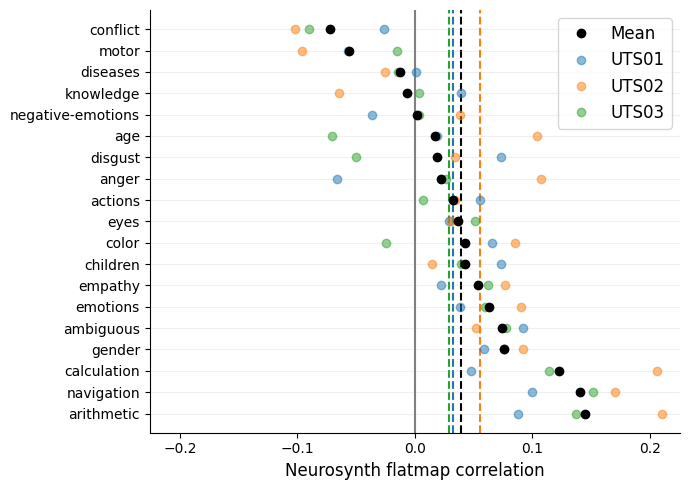

In [13]:
plt.figure(figsize=(7, 5))
colors = {
    'UTS01': 'C0',
    'UTS02': 'C1',
    'UTS03': 'C2',
    'mean': 'black'
}
for subject in ['mean', 'UTS01', 'UTS02', 'UTS03']:
    r_df = corrs_df[corrs_df['subject'] == subject]
    if subject == 'mean':
        idx_sort = r_df['corrs'].sort_values(ascending=False).index

    r_df = r_df.loc[idx_sort]

    # plot corrs
    if subject == 'mean':
        plt.errorbar(
            r_df['corrs'],
            range(len(r_df)),
            color='black',
            fmt='o',
            zorder=1000,
            label=subject.capitalize(),
        )
    else:
        plt.errorbar(
            r_df['corrs'],
            range(len(r_df)),
            # xerr=np.sqrt(
            # r_df['corrs'] * (1-r_df['corrs'])
            # / r_df['num_test']),
            alpha=0.5,
            label=subject.upper(),
            fmt='o')
    plt.axvline(r_df['corrs'].mean(),
                linestyle='--', color=colors[subject], zorder=-1000)

    print('mean corr', r_df['corrs'].mean())

# add horizontal bars
plt.yticks(range(len(r_df)), [term_dict_rev[k] for k in idx_sort])
plt.xlabel(
    'Neurosynth flatmap correlation', fontsize='large')
plt.grid(axis='y', alpha=0.2)
plt.axvline(0, color='gray')

abs_lim = max(np.abs(plt.xlim()))
plt.xlim(-abs_lim, abs_lim)

# annotate with baseline and text label
plt.legend(fontsize='large')
plt.tight_layout()
# plt.savefig('linear_decoding.png', dpi=300)
plt.show()

# Make comparison

In [ ]:
# matches
qa_list = [
    # approx matches
    'Is time mentioned in the input?',
    'Does the input contain a measurement?',
    # 'Does the input contain a number?',
    'Does the sentence mention a specific location?',
    # 'Does the sentence describe a relationship between people?',
    # 'Does the sentence describe a relationship between people?',
    'Does the text describe a mode of communication?',
    # 'Does the sentence contain a negation?',
]
gemv_list = [
    # approx matches
    ('time', 212),
    ('measurements', 171),
    # ('measurements', 171),
    # ('moments',	337),
    # ('locations', 122),
    ('locations', 368),
    # ('emotion', 179),
    # ('emotional expression', 398),
    ('communication', 299),
    # ('negativity', 248)
]


qa_list += [
    'Is the sentence abstract rather than concrete?',
    'Does the sentence contain a cultural reference?',
    'Does the sentence include dialogue?',
    'Is the input related to a specific industry or profession?',
    'Does the sentence contain a negation?',
    'Does the input contain a number?',
    "Does the sentence express the narrator's opinion or judgment about an event or character?",
    'Does the sentence describe a personal or social interaction that leads to a change or revelation?',
    'Does the sentence describe a personal reflection or thought?',
    'Does the sentence involve an expression of personal values or beliefs?',
    'Does the sentence describe a physical action?',
    'Does the input involve planning or organizing?',
    'Does the sentence contain a proper noun?',
    'Does the sentence describe a relationship between people?',
    'Does the sentence describe a sensory experience?',
    'Does the sentence involve the mention of a specific object or item?',
    'Does the sentence include technical or specialized terminology?',
]

gemv_list += [
    ('abstract descriptions', 'qa'),
    ('cultural references', 'qa'),
    ('dialogue', 'qa'),
    ('industry or profession', 'qa'),
    ('negations', 'qa'),
    ('numbers', 'qa'),
    ('opinions or judgments', 'qa'),
    ('personal or interactions interactions', 'qa'),
    ('personal reflections or thoughts', 'qa'),
    ('personal values or beliefs', 'qa'),
    ('physical actions', 'qa'),
    ('planning or organizing', 'qa'),
    ('proper nouns', 'qa'),
    ('relationships between people', 'qa'),
    ('sensory experiences', 'qa'),
    ('specific objects or items', 'qa'),
    ('technical or specialized terminology', 'qa')
]

df_pairs = pd.DataFrame({
    'qa_weight': qa_list,
    'gemv_avg_resp': gemv_list,
})

In [ ]:
subject = 'S02'
df_qa_dict = joblib.load(f'df_qa_dict_{subject.replace("UT", "")}.pkl')

In [ ]:
# for setting in df_qa_dict.keys():
for setting in ['avg']:
    df_qa_weights = df_qa_dict[setting]
    df_pairs = df_pairs[df_pairs['qa_weight'].isin(df_qa_weights.index)]
    flatmaps_qa = df_qa_weights.loc[df_pairs['qa_weight'].values]['weights'].values
    flatmaps_gemv = [gemv_avg_flatmaps[bd]
                     for bd in df_pairs['gemv_avg_resp'].values]

    corrs = viz._calc_corrs(
        flatmaps_qa,
        flatmaps_gemv,
        titles_qa=[analyze_helper.abbrev_question(
            q) for q in df_pairs['qa_weight'].astype(str)],
        titles_gt=df_pairs['gemv_avg_resp'].apply(lambda x: x[0]).astype(str)
    )

    viz.corr_bars(
        corrs,
        out_dir_save=join(repo_dir, 'qa_results', 'hypothesis_tests', setting),
        xlab='GEM-V',
    )
    plt.show()

In [ ]:
# quickshow(wt_qas[0])
# quickshow(wt_gemv[0])
sasc.viz.quickshow(
    flatmaps_qa[0],
    subject="UTS02",
)

In [ ]:
flatmaps_qa[0].shape